In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import Phase_curve_wavelength as PCw
import pandas as pd
from astropy import constants as const
from TRAPPIST1_parameters import *
from scipy import interpolate
from astropy import units as u



(0.0, 5.0)

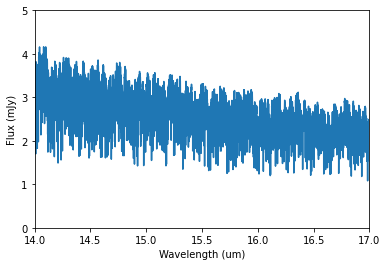

In [16]:
plt.plot(wavelengths_T1_sphinx*1e6, PCw.conversion_IS_to_mJy(F=flux_T1_sphinx, wavelength=wavelengths_T1_sphinx, dist=dist_system, R=R_star), label='Sphinx')
plt.ylabel('Flux (mJy)')
plt.xlabel('Wavelength (um)')
plt.xlim(14, 17)
plt.ylim(0, 5)


In [6]:
PCw.flux_ratio_miri(filter_name =  "F1500W", R_planet = R_b, R_star = R_T1, T_planet = 503)

755.8364540256332

In [9]:
PCw.flux_ratio_miri(filter_name =  "F1280W", R_planet = R_b, R_star = R_T1, T_planet = 503)

594.7141960722138

# Plot emission spectrum + predictions Fp/Fs

Text(0.5, 0, 'Wavelength ($\\mu m$)')

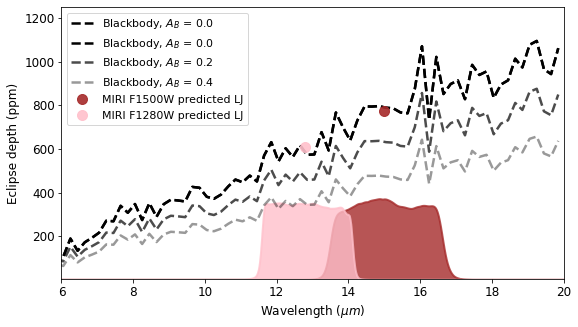

In [44]:
from astropy.modeling.models import BlackBody

def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi

    return binned_x[~nans], binned_y[~nans], binned_error[~nans]
def Tdayside_from_albedo(Ab, Ts= 2566, Rs= 0.1192 * 6.957E10, a= 0.01154 * 1.496E13, f= 2/3):
    Tdayside = Ts * np.sqrt(Rs/(a)) * (f)**(1./4)
    return Tdayside

file_aisha = "sphinx_spectrum_T-1_aisha.txt"
spec_T1_sphinx = pd.read_csv(file_aisha,skiprows=1, delim_whitespace=True, header=None)
spec_T1_sphinx.columns = ["#Wavelength(micrometer)","Flux(W/m2/m)"]
x_T1_sphinx = spec_T1_sphinx["#Wavelength(micrometer)"]
y_T1_sphinx = np.array(spec_T1_sphinx["Flux(W/m2/m)"]) *1e7 / 1e4 * 1e-10  
f_T1_sphinx = interpolate.interp1d(x_T1_sphinx, y_T1_sphinx)

color_plot = 'k'
plt.figure(figsize=(9,5))
ax = plt.gca()

# models BB    
for i, Ab in enumerate(np.arange(0.,0.5,0.2)):
    Tdayside = Tdayside_from_albedo( Ab)
    bb = BlackBody(temperature=Tdayside*u.K, scale=1*u.erg/(u.cm ** 2 * u.s * u.sr *u.AA))
    wav = np.arange(1, 20,0.1) * u.um
    flux_planet = bb(wav)*np.pi   

    # SPHINX
    binned_specT1_sphinx = fast_binning(wav.value,
                                                np.array(flux_planet*(1-Ab)/(f_T1_sphinx(wav)))*(R_b/R_star)**2*1e6,
                                                bins=0.2, )
    
    df_Fig2_BB_1 = pd.DataFrame({"Wavelength":binned_specT1_sphinx[0],"eclipse_depth":binned_specT1_sphinx[1]})
    
    plt.plot(binned_specT1_sphinx[0], binned_specT1_sphinx[1],'--', label=r"Blackbody, $A_B$ = "+"{:.1f}".format(Ab), color='k',alpha=(1-0.3*(i)),linewidth=2.5)
    if Ab == 0:
        plt.plot(binned_specT1_sphinx[0], binned_specT1_sphinx[1],'--', color='k',alpha=(1-0.2*(i)),linewidth=2.5, label=r"Blackbody, $A_B$ = "+"{:.1f}".format(Ab))
        df_Fig2_BB = pd.DataFrame({"Wavelength":binned_specT1_sphinx[0],"eclipse_depth":binned_specT1_sphinx[1]})
        
    df_Fig2_BB = pd.concat([df_Fig2_BB,df_Fig2_BB_1],axis=1)


plt.plot(15, PCw.flux_ratio_miri(filter_name =  "F1500W", R_planet = R_b, R_star = R_star, T_planet = Tdayside), 'o', markersize=10, color='brown', alpha=0.9, label='MIRI F1500W predicted LJ')
plt.plot(12.8, PCw.flux_ratio_miri(filter_name =  "F1280W", R_planet = R_b, R_star = R_star, T_planet = Tdayside), 'o', markersize=10, color='pink', alpha=0.9, label='MIRI F1280W predicted LJ')

ax.fill_between(PCw.filter(filter_name = "F1500W")[0,:], PCw.filter(filter_name = "F1500W")[1,:]*1000, color='brown',alpha=0.8,linewidth=2)
ax.fill_between(PCw.filter(filter_name = "F1280W")[0,:], PCw.filter(filter_name = "F1280W")[1,:]*1000, color='pink',alpha=0.8,linewidth=2)

ax.tick_params(axis="y", labelsize=12, labelcolor=color_plot)
ax.tick_params(axis='x', labelsize=12,labelcolor=color_plot)
ax.yaxis.label.set_color(color_plot)
ax.xaxis.label.set_color(color_plot)
ax.spines['left'].set_color(color_plot) 
ax.spines['bottom'].set_color(color_plot) 
ax.spines['top'].set_color(color_plot) 
ax.spines['right'].set_color(color_plot) 
ax.set_xlim(6,20)
ax.set_ylim(5,1250)
ax.legend(loc=2, fontsize=11, ncol=1)

plt.ylabel("Eclipse depth (ppm)",fontsize=12)
plt.xlabel(r"Wavelength ($\mu m$)",fontsize=12)